# TP2
### Équipe 10
### Fabrice Charbonneau (1798064)
### Sanou Armel Kenzanga Landry (1976804)


# __Q1: Supposons que je lis le document numéro '422908' dans ma matrice. Appliquez l'algorithme Page rank pour déterminer les autres lectures recommandées. En plus de la simple recommandation des références de '422908', appliquez au moins une variation de cette approche de base, comme celle exposée en classe qui consiste à étendre le sous-ensemble S (références) à S' (références des références). Expliquez la démarche que vous avez prise.__

In [1]:
import pandas as pd
import networkx as nx
from itertools import islice
import matplotlib.pyplot as plt

#can be removed
from jupyterthemes import jtplot
jtplot.style()

Le fichier `citeseet.csv` est simplement la `rtable` à l'adresse `http://cours.polymtl.ca/MDesmarais/log6308/Public/citeseer.rtable`. Le code ci-dessous permet de storer les informations dans un dataframe de Pandas.

In [2]:
df = pd.read_csv("citeseer.csv", index_col=0)
df.columns = [int(col[1:]) for col in df.columns]
df.head()

100299  100967  10151   101705  101863  102458  102886  102966  \
100299       0       0       0       0       0       0       0       0   
100967       0       0       0       0       0       0       0       0   
10151        0       0       1       0       0       0       0       0   
101705       0       0       0       0       0       0       0       0   
101863       0       0       0       0       0       0       0       0   

        10302   103700  ...  96767   97060   97150   9721    97410   97863   \
100299       0       0  ...       0       0       0       0       0       0   
100967       0       0  ...       0       0       0       0       0       0   
10151        0       0  ...       0       0       0       0       0       0   
101705       0       0  ...       0       0       0       0       0       0   
101863       0       0  ...       0       0       0       0       0       0   

        98185   99113   9947    9993    
100299       0       0       0       0  
100967       0       0       0       0  
10151        0       0       0       0  
101705       0       0       0       0  
101863       0       0       0       0  

[5 rows x 1090 columns]

## Représentation des données

La librarie `networkx` permet de prendre le dataframe et d'en faire un objet représentant un graphe. Cela permet de manipuler plus facilement les articles.

[Networkx](https://networkx.github.io/documentation/stable/)

In [3]:
G_di = nx.from_pandas_adjacency(df, create_using=nx.DiGraph())
nx.info(G_di)

'Name: \nType: DiGraph\nNumber of nodes: 1090\nNumber of edges: 2882\nAverage in degree:   2.6440\nAverage out degree:   2.6440'

/home/fabrice/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/fabrice/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


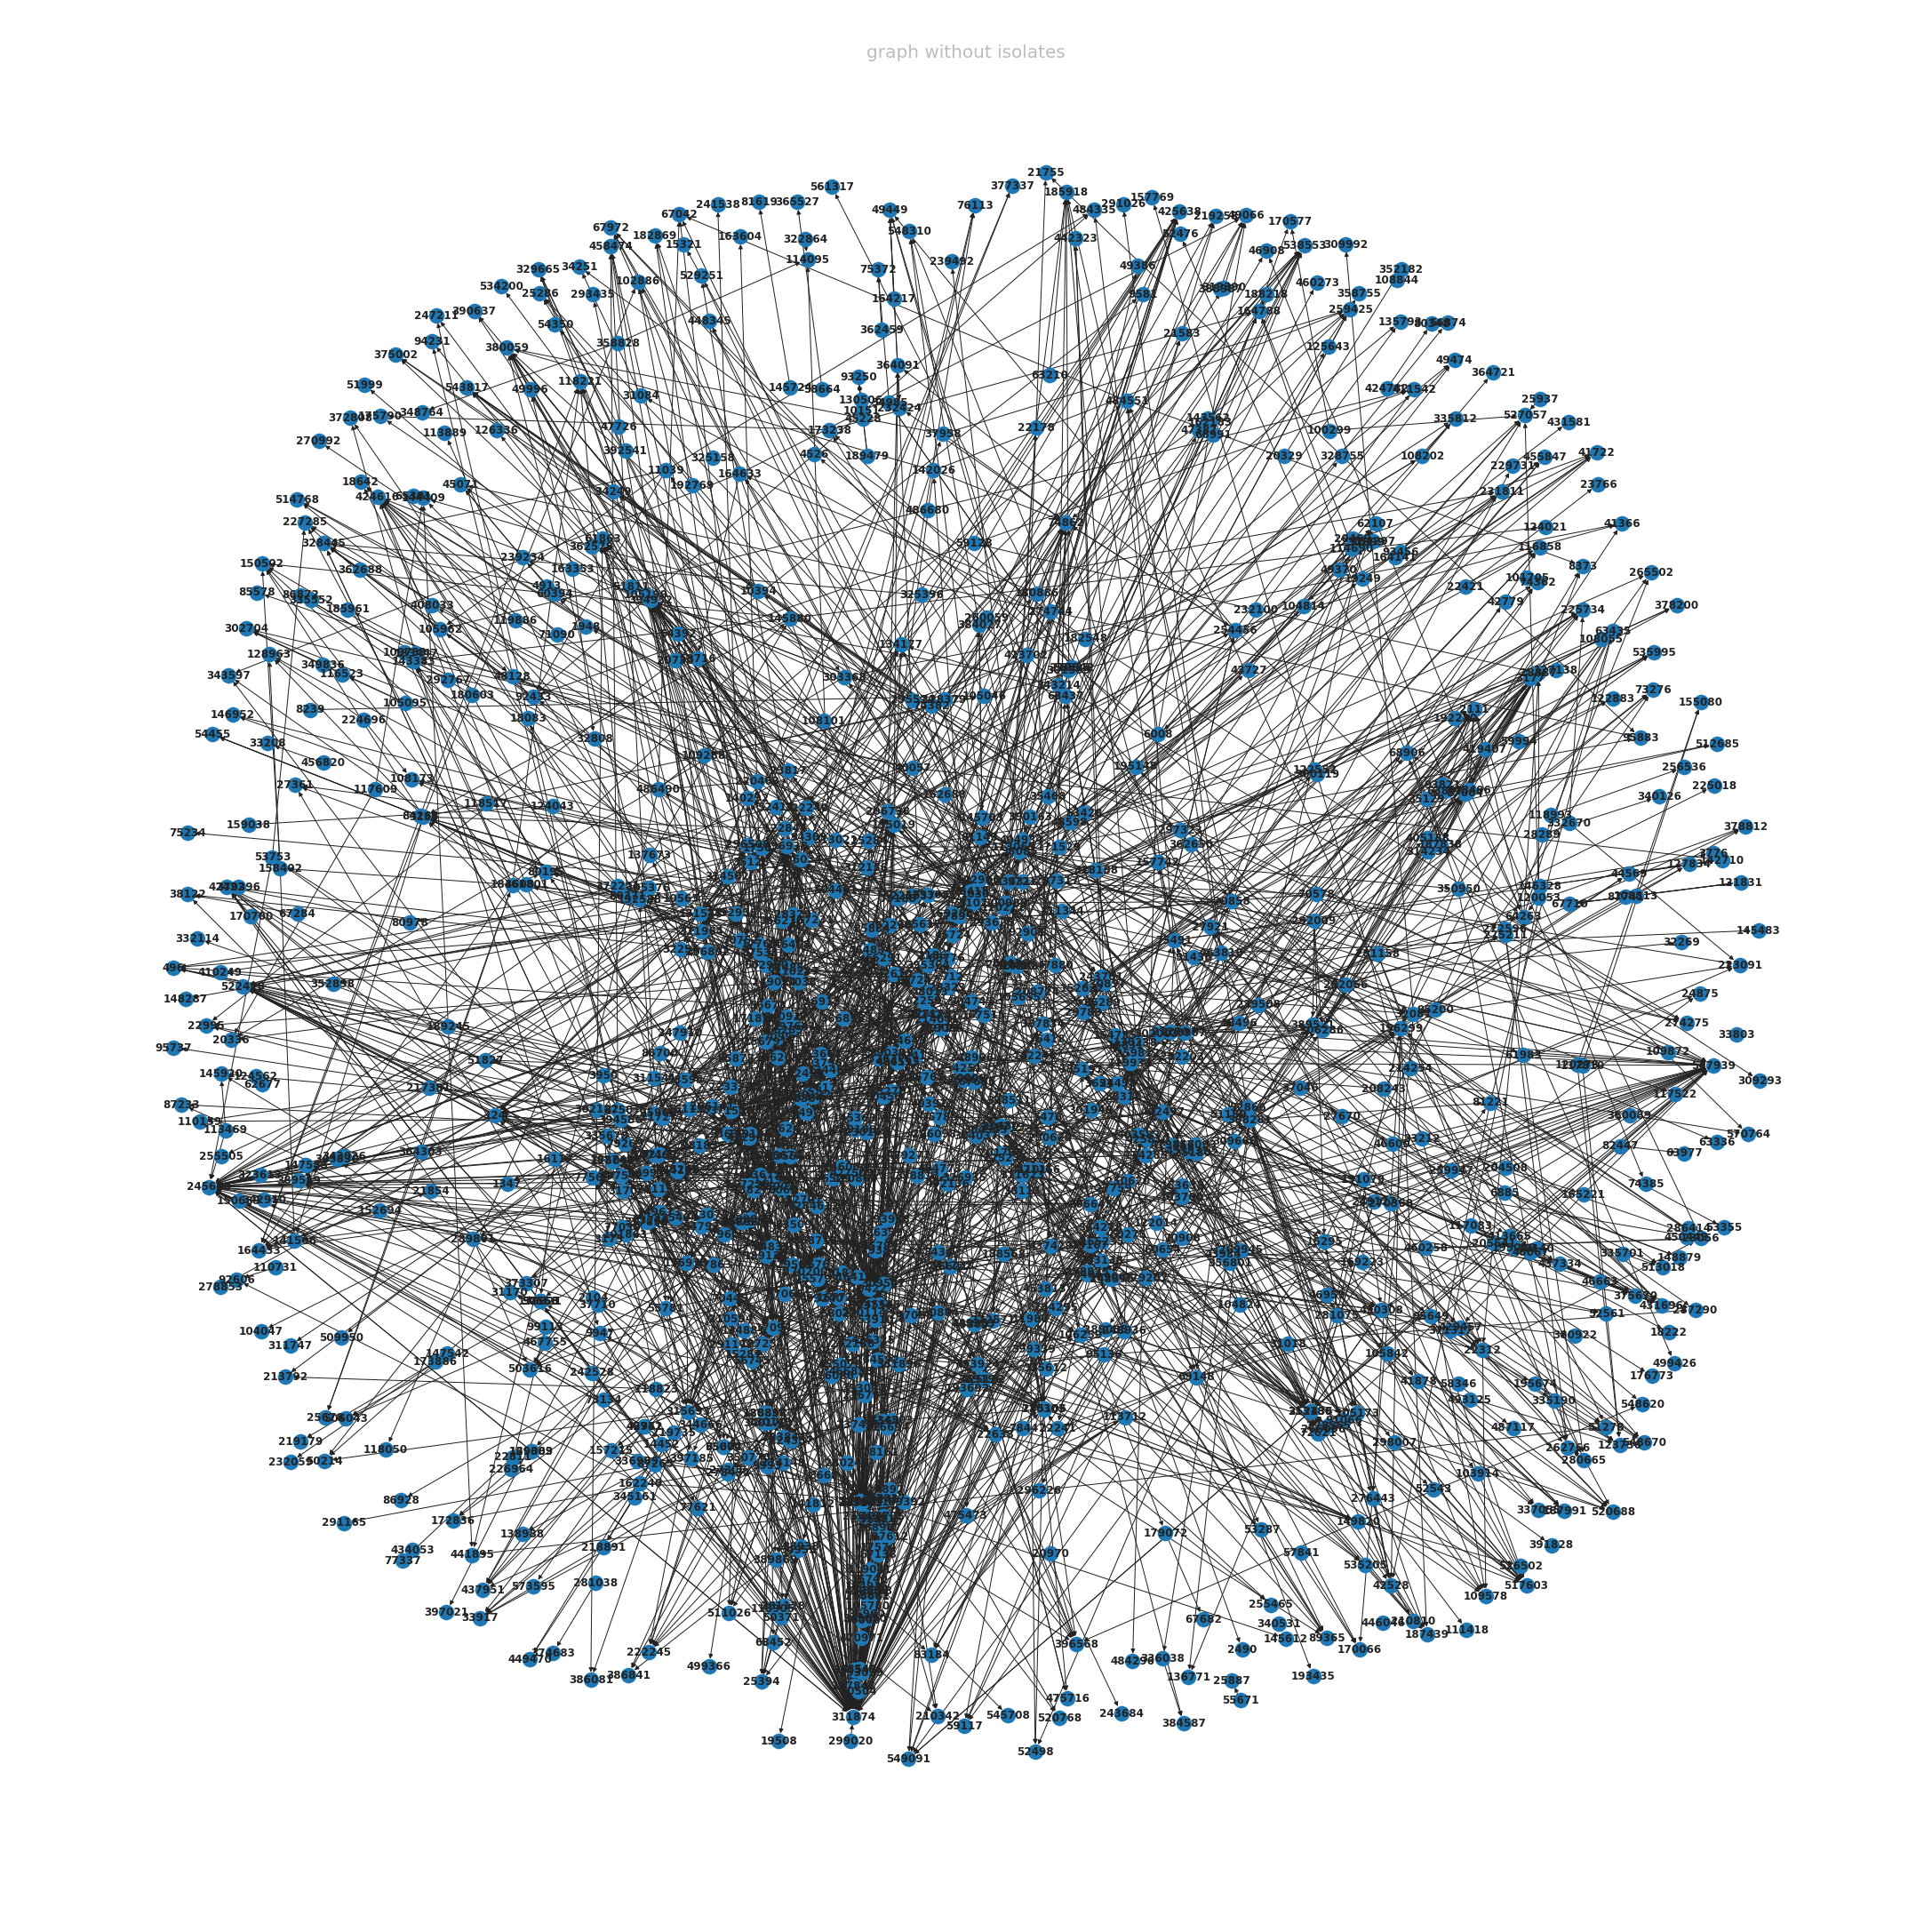

In [29]:
generate_graph = True #change this to show a graph output
if generate_graph:
    G_no_isolates = G_di
    G_no_isolates.remove_nodes_from(list(nx.isolates(G_di)))
    fig = plt.figure(figsize=(30, 30))
    fig.suptitle("graph without isolates", fontsize=20)
    nx.draw(G_no_isolates, with_labels=True, font_weight='bold')
    plt.show()

## Pagerank

La librarie permet entre autres d'[appliquer l'algorithme de PageRank](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank_numpy.html) sur un graphe. 
Une autre fonction possible dans la librarie permet d'appliquer [une variante](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html) qui converti tous les arêtes en arête bidirectionnel, ignorant alors le sens des liens entre les articles.

In [5]:
pr = nx.pagerank_numpy(G_di)
#print some to make sure they make sense
list(islice(pr.items(), 5))

[(100299, 0.00038774674668394906),
 (100967, 0.0006135099384654465),
 (10151, 0.0007016369701899621),
 (101705, 0.00038774674668394055),
 (101863, 0.0004333727205142751)]

In [6]:
pr[422908]

0.0064287113132561425

## Fonction générale
La fonction `get_top_recommendations` ci-dessous ne comporte pas directement de calcul de pagerank. Elle ne fait que prendre un article, un graphe, et un dictionnaire `key=article value=pagerank_score` afin de redonner les recommandations selon le nombre de recommandations et le niveau d'ensembles voulus.

Par exemple, `max_deepness=1` indique que l'on veut se limiter à S et `max_deepness=2` indique que l'on veut également considérer les articles se trouvant dans l'ensemble S'. 

`graph.neighbors(n)` [retourne tous les noeuds m où il existe une arête de n qui pointe vers m](https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.DiGraph.neighbors.html).

In [7]:
def get_top_recommendations_pagerank(page_ranks, graph, article, n_recommendations=10, max_deepness=1):
    possible_article_recommendations = []
    last_discovered_nodes = [article]
    deepness_reached = 0
    while deepness_reached <= max_deepness:
        new_discovered_nodes = []
        for discovered_node in last_discovered_nodes:
            for neighbor in graph.neighbors(discovered_node):
                new_discovered_nodes.append(neighbor)
                if neighbor not in possible_article_recommendations and neighbor != article:
                    possible_article_recommendations.append(neighbor)
        last_discovered_nodes = new_discovered_nodes
        deepness_reached += 1
    pr_neighbors = {article_key:page_ranks[article_key] for article_key in possible_article_recommendations}
    return sorted(pr_neighbors, key=pr_neighbors.get, reverse=True)[:n_recommendations] 

## Variations à l'approche Pagerank de base
D'abord, nous allons tenter l'expérience avec S' au lieu de S seulement. 

De plus, nous allons tenter une autre approche, qui est de considérer un graphe non-orienté. Nous justifions l'essai de cette alternative en supposant que les articles peuvent être tout autant pertinents même s'il ne sont pas référencés par l'article de départ, en autant qu'ils référencient celui-ci. Autrement dit, selon cette approche, que ce soit n->m ou m->n, l'important est simplement qu'il y ait un lien entre ces articles, le sens n'a plus ou moins d'importance..

## Résultats
Les résultats suivants représentent les recommandations d'articles pour S et S' ainsi que S et S' pour une variante de l'algorithme de pagerank qui considère tous les arêtes du graphe comme bidirectionnelles. 

In [8]:
document = 422908
results = {}

In [9]:
# S
results["Pagerank S"] = get_top_recommendations_pagerank(pr, G_di, document)
print(results["Pagerank S"])

# S'
results["Pagerank S\'"] = get_top_recommendations_pagerank(pr, G_di, document, max_deepness=2)
print(results["Pagerank S\'"])

[311874, 19422, 17094, 70445, 206738, 225173, 155792, 64835, 396568, 522428]
[311874, 19422, 17094, 70445, 206738, 61863, 225173, 155792, 64835, 396568]


On peut voir que les résultats sont identiques pour les 5 premières recommendations. Par contre, à la sixième recommendation, les deux approches divergent avec S' qui contient un article avec un score pagerank assez élevé pour faire partie des recommendations (61863) que S ne contient pas.

L'expérience qui suit présente une autre approche, qui est d'appliquer [pagerank en ignorant la direction des arêtes](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html) entre les articles.

In [10]:
G_undi = nx.from_pandas_adjacency(df) # creates an undirected graph
pr = nx.pagerank(G_undi)

# S
results["pr undirected S"] = get_top_recommendations_pagerank(pr, G_undi, document)
print(results["pr undirected S"])

# S'
results["pr undirected S\'"] = get_top_recommendations_pagerank(pr, G_undi, document, max_deepness=2)
print(results["pr undirected S\'"])

[311874, 19422, 38085, 245669, 164643, 547939, 220337, 500980, 371548, 83263]
[311874, 19422, 38085, 245669, 164643, 547939, 220337, 500980, 368281, 371548]


On peut voir qu'avec cette approche, les articles recommandés diffèrent de l'aproche de base après les deux premiers, et que de nouveaux articles font surface (38085, 245669, 164643, 547939, 220337, 500980, 371548, 368281, 83263).

## Discussion
TODO: discuter de la qualité des résultats (quand l'API du prof va marcher) 

# __Q2: Comparez les résultats obtenus avec une approche basée sur la similarité des articles dans un espace vectoriel, à l'instar du calcul de similarité de l'approche item-item. La mesure de la similarité et la façon de l'utiliser pour estimer la pertinence d'articles similaires est laissé à votre discrétion.__

L'idéal serait de comparer les descriptions entre elles avec du NLP afin de déterminer un score de similarité entre l'article 422908 et chacun des autres articles. 

Par contre, l'approche que nous allons utiliser ici est de comparer les vecteurs de références d'articles et appliquer le cosinus afin de recommander des articles.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [12]:
def get_top_recommendations_cosine(dataframe, article, n_recommendations=10):
    df_cos = dataframe.copy()
    df_cos[:] = cosine_similarity(df_cos)
    df_cos = df_cos.sort_values(by=article, ascending=False)
    return list(df_cos[1:n_recommendations + 1].index)

## Résultats et comparaison

In [13]:
results["cosine item-item"] = get_top_recommendations_cosine(df, document)
for key in results.keys():
    print("      " + key + "\t" + str(results[key]))

      Pagerank S	[311874, 19422, 17094, 70445, 206738, 225173, 155792, 64835, 396568, 522428]
      Pagerank S'	[311874, 19422, 17094, 70445, 206738, 61863, 225173, 155792, 64835, 396568]
      pr undirected S	[311874, 19422, 38085, 245669, 164643, 547939, 220337, 500980, 371548, 83263]
      pr undirected S'	[311874, 19422, 38085, 245669, 164643, 547939, 220337, 500980, 368281, 371548]
      cosine item-item	[96767, 70445, 466838, 149673, 53632, 155792, 497542, 3175, 17507, 17094]


## Discussion

On peut constater que les recommandations selon l'approche item-item avec le cosinus présente des résultats assez différents des deux approches précédentes. La plupart des articles recommandés n'étaient pas présents dans les recommandations de Pagerank. Par contre, on y retrouve des articles qui avaient déjà été détectés par Pagerank: 70445, 155792 et 17094.

On peut donc confirmer que les deux approches semblent bien fonctionner, car certains résultats se retrouve dans les deux ensembles. Par contre, elles donnent des résultats plutôt différents.

Il serait raisonnable d'imaginer une solution combinant les deux approches, ce qui permettrait d'avoir un grand ensemble de solutions possibles, et il serait possible de donner un meilleur score aux solutions qui seraient trouvées par les deux approches simultanément.

# __Q3:  Utilisez une validation croisée pour évaluer la performance de l'approche item-item.__ Vous pouvez vous inspirer de l'approche utilisée dans l'article suivant pour la méthodologie à adopter:
McNee, S. M., Albert, I., Cosley, D., Gopalkrishnan, P., Lam, S. K., Rashid, A., Konstan, J. A., and Riedl, J. 2002. On the recommending of citations for research papers. In Proceedings of the 2002 ACM Conference on Computer Supported Cooperative Work (New Orleans, Louisiana, USA, November 16 - 20, 2002). CSCW '02. ACM, New York, NY, 116-125. DOI=http://doi.acm.org/10.1145/587078.587096
### Cependant, vous pouvez aussi adapter cette méthodologie ou en définir une différente. Par exemple, les "observations" que l'on peut vraisemblablement considérer comme valables pour les tests sont les références d'ordre 1 et 2 de la matrice d'adjacence et de sa transposée. Compte tenu du faible nombre de références, il est préférable d'adopter une approche "leave one out", où une seule "observation" est retirée du corpus à la fois, et où l'on compare une mesure du degré de confiance à prédire cette observation.

## Approche: calcul du degré de confiance des observations (références effectives) d'un article

D'abord, redéfinissons une fonction permettant de calculer seulement les scores cosinus des articles et qui retourne la moyenne des degré de confiance à prédire un article référencé par un article donné. Nous supposons ici un nombre de recommandations de 10, un degré de confiance étant égal à la moyenne des positions de l'article dans la liste de recommendation, cette position étant nulle s'il ne se trouve pas dans la liste des 10 recommandations. Pour chaque article référencé par l'article donnée, nous remplaçons `1` par `0` et nous appliquons cosinus sur les données comprenant cette modification.

Il est à noter que pour rendre les résultats cohérent, nous prenons la liste de recommandations et nous prenons l'index dans cette liste inversée. Ainsi, les articles se trouvant à la fin de la liste ont plus de points que les articles se trouvant au début, rendant alors l'index dans la liste un bon indicateur du degré de confiance de l'algorithme.

In [22]:
# Returns: (cummulated confidence/ positions in recommendations), number of 'real' articles referenced)
def single_cross_val_average_confidence(dataframe, article_index, n_recommendations=10):
    df_cos = dataframe.copy()
    article = df_cos.iloc[[article_index]].index[0]
    df_article = dataframe.loc[[article]].copy()
    columns = list(df_article)
    cummulated_position = 0
    n_reals = 0
    n_recommendations = 10
    for i in columns:
        art = df_article.copy()
        if art.iloc[0][i] == 1:
            n_reals += 1
            art.iloc[0][1] = 0
            df_cos[:] = cosine_similarity(df_cos, np.tile(art, (df_cos.shape[0],1)))
            df_cos = df_cos.sort_values(by=article, ascending=False)
            recommendations = list(df_cos[1:n_recommendations + 1].index)
            if i in recommendations:
                cummulated_position += (recommendations[::-1].index(i) + 1) #+1 to get index between 1 and 10 instead of 0 and 9
    if(n_reals > 0):
        return (cummulated_position/n_reals, n_reals)
    return (0, 0)

In [23]:
# test
single_cross_val_average_confidence(df, 2)

(0.0, 1)

## Résultats: accumulation des degrés de confiance

Nous allons ici utiliser l'approche *Leave One Out* afin d'effectuer une validation croisée sur le dataframe. La librairie sklearn possède une fonction permettant de faire cela.

In [24]:
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import shuffle
df = shuffle(df)
cross_validation_set = LeaveOneOut()
cross_validation_set.get_n_splits(df)

1090

Pour des raisons de temps d'exécution, nous allons nous contenter de calculer la performance pour uniquement 50 articles au lieu de 1090. Il est à noter qu'il serait idéal de le faire sur l'ensemble des données afin d'obtenir une mesure plus précise.

Puisque nous avons aléatoirement mélangé le dataset, on s'assure d'obtenir une mesure pouvant être généralisée sur l'ensemble des données.

In [26]:
MAX_ITER = 50
confidence = 0
n_non_empty_articles = 0
total_estimations = 0
for train_index, test_index in cross_validation_set.split(df):
    if n_non_empty_articles > MAX_ITER:
        break;
    train_df = df.iloc[train_index, :]
    result = single_cross_val_average_confidence(df, test_index[0])
    if result[1] > 0:
        n_non_empty_articles += 1
        total_estimations += result[1]
        confidence += result[0]
confidence/(n_non_empty_articles*10)

0.07985814838756015

In [28]:
total_estimations

182

## Discussion
Tout d'abord, il faut préciser que la performance obtenue est un nombre borné entre 0 et 1, 1 indiquant que le modèle est *confiant*, c'est à dire qu'il tend à mettre l'article *left out* en premier dans la liste de 10 recommandations, et 0 absent de la liste. Le nombre obtenu est proportionnel à la position de l'article dans la liste de recommandations.

La performance de l'approche item-item avec le cosinus donnée par la validation croisée est probablement plus basse que ce à quoi on s'attendrait, car de nombreux articles ont peu de référence, faisant en sorte qu'il devient difficile pour l'approche item-item cosinus de pouvoir comparer des vecteurs creux. On peut par exemple observer que pour nos 50 articles, nous n'avons que 182 références effectives. Cela indique que la plupart des articles ont en moyenne moins de 4 références sur les 1090 articles possibles.

Toutefois,la performance obtenue est très basse. Une interprétation possible est qu'environ 8 fois sur 10, l'article se trouve en dernière position, et le reste, pas dans la liste du tout. De meilleurs résultats auraient pu être obtenus avec un algorithme plus complexe comme du NLP afin d'obtenir de meilleurs indicateurs de similarités entre les articles, ou encore pageranks, qui se base sur les références elles-mêmes et qui sont alors plus propices à obtenir de meilleurs performances en utilisant cette méthode de validation.